In [1]:
# import python packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy import signal
import pylab
from pykalman import KalmanFilter
import time
from sklearn.decomposition import FactorAnalysis
import pickle

In [2]:
# local own implementations
%load_ext autoreload
%autoreload 2
from PLDS_Macke2015 import PLDS, EM
#from PLDS_Macke2015_evaluation import fit_to_all_trials

def standard(x):
    return (x-np.nanmean(x))/np.sqrt(np.nanvar(x))

# simulate data

## simulate LDS latent and PLDS data

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcbc85ab2d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbd900d490>)

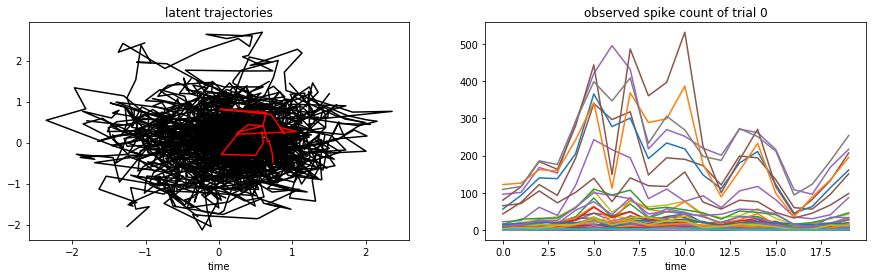

In [3]:
# noise type
poisson = True
#### parameters used ####
seed =1
np.random.seed(seed)
# linear Gaussian
n_step = np.array([20])
Ttrials = 100

# latent
xdim = 2
#A = np.array([[0., 1.],[-4., 0.]]).T* np.array([.5]) # np.array([[0.9, -0.1],  [0.3, 0.7]]) #np.array([[0., 1.],[-4., 0.]])* np.array([.5])#  *  #  
A = 0.9*np.eye(xdim) # np.array([[0.9, 0.1],  [0.3, 0.7]]) #np.array([[0., 1.],[-4., 0.]])* np.array([.5])#  *  #  np.eye(xdim) # 
sigQ = 0.1 #.5
Q = np.eye(xdim)*sigQ # np.array([[1, 0.1],[0.1, 1]]) # 
Q0 = np.eye(xdim)*sigQ
x0 = np.zeros([xdim])+np.random.randn(2)*.1
# observed
ydim = 100
cscal = 2
C = cscal*np.random.rand(ydim*xdim).reshape(ydim, xdim)
R = np.eye(ydim)*.01
# stimulus
sdim = 1
B = cscal*np.ones([ydim,sdim])*np.random.randn(ydim, sdim)
S = np.ones([n_step[0], sdim, Ttrials])
if sdim>1:
    S[:,0,:] = np.round(np.random.rand(n_step[0]*Ttrials)).reshape(n_step[0],Ttrials)
S = np.array(S, dtype='int')

MOD = PLDS(xdim=xdim, ydim=ydim, n_step=n_step, C=C, Q0=Q0, A=A, Q=Q, x0=x0,R=R,
        Ttrials=Ttrials, B=B)
MOD.sample(poisson=poisson, X=S)
MOD.vis_xy()

# inference

In [4]:
ttrial=0
print('test for likelihood function P(y|x)')
MOD.test_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial], 
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
MOD.test_J_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial],
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
MOD.test_H_log_lik(MOD.x[:MOD.n_step[ttrial],:,ttrial], 
                MOD.B, MOD.C, Rtmp=MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])
print(' ')
print('test for prior function Px)')
MOD.test_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0, MOD.x0)
MOD.test_J_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0, MOD.x0)
MOD.test_H_log_prior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.A, 
                     MOD.Q, MOD.Q0)
print(' ')
print('test for block-list conversion')
MOD.test_block(np.round(MOD.H_log_posterior(MOD.x[:MOD.n_step[ttrial],:,ttrial], MOD.y[:MOD.n_step[ttrial],:,ttrial], MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, poisson=poisson, X=S[:MOD.n_step[ttrial],:,ttrial])), mdim=[MOD.xdim, MOD.xdim], offdiag=1)

test for likelihood function P(y|x)
----- TEST PASSED -----
----- TEST PASSED -----
----- TEST PASSED -----
 
test for prior function Px)
----- TEST PASSED -----
----- TEST PASSED -----
----- TEST PASSED -----
 
test for block-list conversion
----- TEST PASSED -----


In [17]:
from scipy.optimize import minimize

In [18]:
Xtmp0 = np.sqrt(np.nanvar(MOD.x))*np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2])

Xres = MOD.inference(Xtmp0, MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, X=S, poisson=poisson, 
              disp=True, xtol=1e-10)



         Current function value: -143725.554929
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 48
         Hessian evaluations: 24
         Current function value: -68719.164870
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 44
         Hessian evaluations: 22
         Current function value: -189909.965862
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 42
         Hessian evaluations: 21
         Current function value: -33402.409257
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 43
         Hessian evaluations: 21
         Current function value: -66190.102324
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 42
         Hessian evaluations: 21
         Current function value: -368826.763425
         Iterations: 20
         Function evaluations: 98
         Gradient evaluations: 1

         Current function value: -197472.513000
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 42
         Hessian evaluations: 20
         Current function value: -110493.724678
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 45
         Hessian evaluations: 22
Optimization terminated successfully.
         Current function value: -78977.918436
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 45
         Hessian evaluations: 21
         Current function value: -62394.179236
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 39
         Hessian evaluations: 20
Optimization terminated successfully.
         Current function value: -111730.607184
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 45
         Hessian evaluations: 21
         Current function value: -91159.089314
         Itera

         Current function value: -42957.030329
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 37
         Hessian evaluations: 19
         Current function value: -218977.048473
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 44
         Hessian evaluations: 22
         Current function value: -16477.424110
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 37
         Hessian evaluations: 19
Optimization terminated successfully.
         Current function value: -38959.626877
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 43
         Hessian evaluations: 20
         Current function value: -130199.378179
         Iterations: 20
         Function evaluations: 89
         Gradient evaluations: 97
         Hessian evaluations: 21
         Current function value: -57527.754029
         Iterations: 20
         Function evaluations

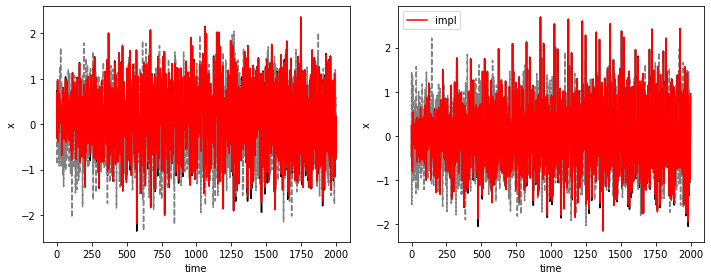

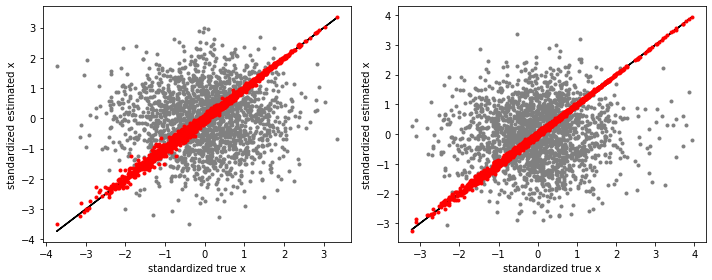

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(MOD.x[:,ff,:].ravel(), '-k')
    ax[ff].plot(Xtmp0[:,ff,:].ravel(), '--', color='grey')
    ax[ff].plot(Xres[:,ff,:].ravel(), '-r', label='impl')
    ax[ff].set_xlabel('time')
    ax[ff].set_ylabel('x')
ax[ff].legend()
fig.tight_layout()
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
               standard(MOD.x[:,ff,:].ravel()), '-k')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
                standard(Xtmp0[:,ff,:].ravel()),'.', color='grey')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xres[:,ff,:].ravel()),'r.')
    ax[ff].set_xlabel('standardized true x')
    ax[ff].set_ylabel('standardized estimated x')
fig.tight_layout()

In [20]:
if poisson: 
    R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
    y = MOD.y.copy()
    y[y<=0] = 1e-10
    y = np.log(y)
else: 
    R = MOD.R.copy()
    y = MOD.y.copy()
Xkal = np.zeros(MOD.x.shape)*np.nan
for ttrial in range(MOD.Ttrials):
    kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                     transition_matrices=MOD.A,
                     transition_covariance=MOD.Q,
                     observation_matrices=MOD.C,
                     observation_covariance=R, 
                     initial_state_mean=MOD.x0,
                     initial_state_covariance=MOD.Q0)
    # Kalman filtering
    filtered_state_means, filtered_state_covariances = kf.filter(y[:,:,ttrial])
    # Kalman smoothing
    smoothed_state_means, smoothed_state_covariances = kf.smooth(y[:,:,ttrial])
    Xkal[:,:,ttrial] = smoothed_state_means

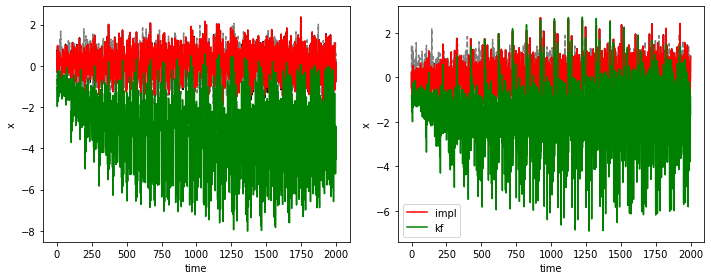

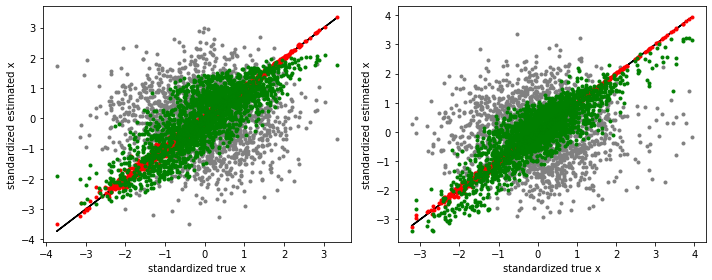

In [21]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(MOD.x[:,ff,:].ravel(), '-k')
    ax[ff].plot(Xtmp0[:,ff,:].ravel(), '--', color='grey')
    ax[ff].plot(Xres[:,ff,:].ravel(), '-r', label='impl')
    ax[ff].plot(Xkal[:,ff,:].ravel(), '-g', label='kf')
    ax[ff].set_xlabel('time')
    ax[ff].set_ylabel('x')
ax[ff].legend()
fig.tight_layout()
fig, ax = plt.subplots(1,2,figsize=(10,4))
for ff in range(MOD.xdim):
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
               standard(MOD.x[:,ff,:].ravel()), '-k')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()),
                standard(Xtmp0[:,ff,:].ravel()),'.', color='grey')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xres[:,ff,:].ravel()),'r.')
    ax[ff].plot(standard(MOD.x[:,ff,:].ravel()), 
                standard(Xkal[:,ff,:].ravel()),'g.')
    ax[ff].set_xlabel('standardized true x')
    ax[ff].set_ylabel('standardized estimated x')
fig.tight_layout()

### if y was noiseless (= rate)

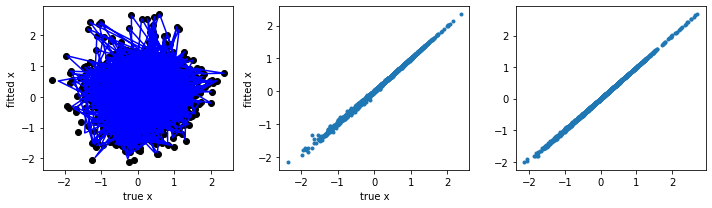

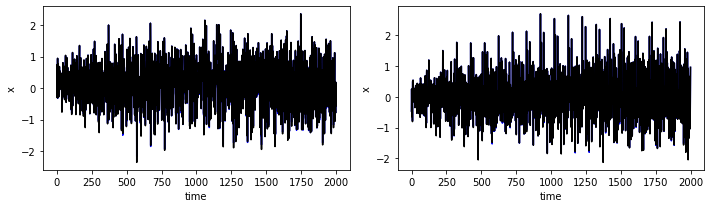

In [22]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T


X0 = np.sqrt(np.nanvar(MOD.x))*np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2])

mu = MOD.inference(X0, ytmp, MOD.B, MOD.C, MOD.A, MOD.Q, 
              MOD.Q0, MOD.x0, MOD.R, X=S, poisson=poisson, 
              disp=False, xtol=1e-10)

#mu, sigma = MOD.E_step(MOD.x,ytmp, MOD.B, MOD.C, MOD.A, MOD.Q, 
#                      MOD.Q0, MOD.x0, MOD.R, X=S,
#                       poisson=poisson, disp=False)
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].plot(MOD.x[:,0,:].ravel(),MOD.x[:,1,:].ravel(), 'ok')
ax[0].plot(mu[:,0,:].ravel(),mu[:,1,:].ravel(), 'b')
ax[0].set_xlabel('x dim 1')
ax[0].set_xlabel('x dim 2')
ax[1].plot(MOD.x[:,0,:].ravel(), mu[:,0,:].ravel(), '.')  
ax[2].plot(MOD.x[:,1,:].ravel(), mu[:,1,:].ravel(), '.')  
for aa in range(2):
    ax[aa].set_xlabel('true x')
    ax[aa].set_ylabel('fitted x')
fig.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(mu[:,0,:].ravel(), 'b')
ax[0].plot(MOD.x[:,0,:].ravel(), 'k')
ax[1].plot(mu[:,1,:].ravel(), 'b')
ax[1].plot(MOD.x[:,1,:].ravel(), 'k')
for aa in range(2):
    ax[aa].set_xlabel('time')
    ax[aa].set_ylabel('x')
fig.tight_layout()

# learning

In [5]:
# noiseless (xtmp, ytmp) versus with noise MOD.y
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
if poisson: 
    R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
    y = MOD.y.copy()
    y[y<=0] = 1e-10
    y = np.log(y)
else: 
    R = MOD.R.copy()
    y = MOD.y.copy()

In [6]:
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 #initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0
                 )
kf.em(y[:,:,0], n_iter=20)
print('x0 from KF: \n', kf.initial_state_mean)
print('x0 from impl: \n', np.round(MOD.upx0(mu),4))
print('true x0: \n', MOD.x0)

x0 from KF: 
 [-1.0514896  -0.84726819]
x0 from impl: 
 [ 0.1953 -0.0114]
true x0: 
 [ 0.16243454 -0.06117564]


In [25]:
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 #initial_state_covariance=MOD.Q0
                 )
kf.em(y[:,:,0], n_iter=20)
print('Q0 from KF: \n', kf.initial_state_covariance)
print('Q0 from impl: \n', np.round(MOD.upQ0(MOD.x0, mu, [sigma[kk][0][0] for kk in range(MOD.Ttrials)]),4))
print('true Q0: \n', MOD.Q0)

Q0 from KF: 
 [[1.40093337e-04 8.46672743e-05]
 [8.46672743e-05 6.29518965e-05]]
Q0 from impl: 
 [[0.116  0.0103]
 [0.0103 0.1007]]
true Q0: 
 [[0.1 0. ]
 [0.  0.1]]


In [26]:
if poisson: R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
else: R = MOD.R.copy()
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 transition_matrices=MOD.A,
                 #transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0)
kf.em(y[:,:,0], n_iter=20)
print('Q from KF: \n', kf.transition_covariance)
print('Q from impl: \n', np.round(MOD.upQ(MOD.A, mu, sigma),6))
print('true Q: \n', MOD.Q)

Q from KF: 
 [[0.09547289 0.03993572]
 [0.03993572 0.01948832]]
Q from impl: 
 [[ 0.005385 -0.000761]
 [-0.000761  0.006418]]
true Q: 
 [[0.1 0. ]
 [0.  0.1]]


In [27]:
if poisson: R = np.eye(MOD.ydim)*np.sqrt(np.nanvar(MOD.y))
else: R = MOD.R.copy()
kf = KalmanFilter(n_dim_state=MOD.xdim, n_dim_obs=MOD.ydim,
                 #transition_matrices=MOD.A,
                 transition_covariance=MOD.Q,
                 observation_matrices=MOD.C,
                 observation_covariance=R, 
                 initial_state_mean=MOD.x0,
                 initial_state_covariance=MOD.Q0)
kf.em(y[:,:,0], n_iter=20)
print('A from KF: \n', kf.transition_matrices)
print('A from impl: \n', np.round(MOD.upA(mu, sigma),3))
print('true A: \n', MOD.A)

A from KF: 
 [[1. 0.]
 [0. 1.]]
A from impl: 
 [[0.911 0.008]
 [0.017 0.914]]
true A: 
 [[0.9 0. ]
 [0.  0.9]]


### parameters of observation mode


In [7]:
# noiseless (xtmp, ytmp) versus with noise
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)

In [9]:
print('L(x) for true x: ', -MOD.L_dyn(MOD.x, mu, sigma, MOD.x0, MOD.Q0))
print('L(x) for random x: ', -MOD.L_dyn(np.random.randn(MOD.x.shape[0], MOD.x.shape[1], MOD.x.shape[2]),
          mu, sigma, MOD.x0, MOD.Q0))

L(x) for true x:  276777.9885826678
L(x) for random x:  -19073686.367379017


B closed form solution


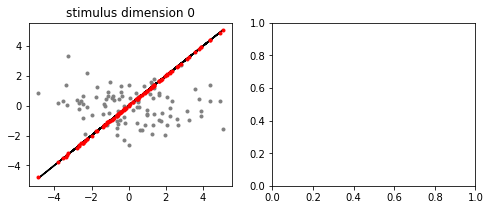

In [10]:
B0 = np.random.randn(MOD.B.shape[0], MOD.B.shape[1])
Best = MOD.upB(B0, MOD.C, MOD.y, mu, sigma, X=S, Rtmp=MOD.R,
             disp=True, gtol=1e-02, maxiter=10, poisson=poisson)
fig, ax = plt.subplots(1,np.max([2,MOD.B.shape[1]]),figsize=(8,3))
for bb in range(MOD.B.shape[1]):
    ax[bb].plot(MOD.B[:,bb], MOD.B[:,bb], '-k')
    ax[bb].plot(MOD.B[:,bb], B0[:,bb], '.', color='grey')
    ax[bb].plot(MOD.B[:,bb], Best[:,bb], '.r')
    ax[bb].set_title('stimulus dimension '+np.str(bb))

### (numerical approx of C with Gaussian noise not yet working)

In [12]:
C0 = np.random.randn(MOD.ydim, MOD.xdim)
Cest = MOD.upC(C0, MOD.B, MOD.y, mu, sigma, X=S, Rtmp=MOD.R,
        disp=True, gtol=1e-5, maxiter=10, poisson=poisson)

         Current function value: -16278566.519154
         Iterations: 10
         Function evaluations: 16
         Gradient evaluations: 16


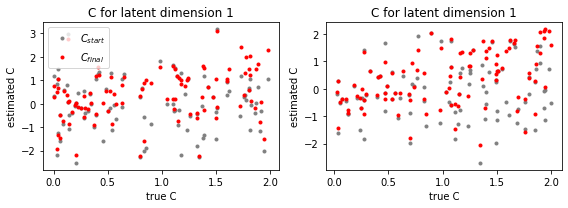

In [13]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(2):
    ax[xx].plot(MOD.C[:,xx], C0[:,xx], '.', color='grey', label='$C_{start}$')
    ax[xx].plot(MOD.C[:,xx], Cest[:,xx], '.r', label='$C_{final}$')
    ax[xx].set_title('C for latent dimension '+np.str(bb+1))
    ax[xx].set_xlabel('true C')
    ax[xx].set_ylabel('estimated C')
ax[0].legend()
fig.tight_layout()

### test: gradient of neg lower bound given noiseless data

using noiseless y:

neg lower bound given random C:  -12611948.009543397
neg lower bound given true C:  -19037003.72241198


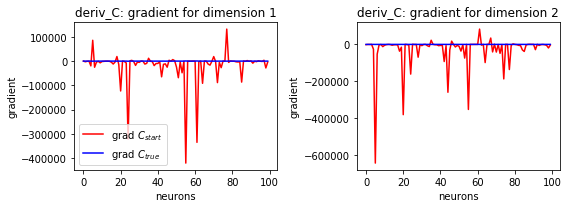

In [15]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
print('using noiseless y:\n')
print('neg lower bound given random C: ', MOD.L_obs(C0, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson))
print('neg lower bound given true C: ',MOD.L_obs(MOD.C, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson))
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(2):
    ax[xx].plot(MOD.J_L_obs_C(C0, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson)[:,xx], 'r', label='grad $C_{start}$')
    ax[xx].plot(MOD.J_L_obs_C(MOD.C, MOD.B, ytmp, mu, sigma, X=S,Rtmp=MOD.R, poisson=poisson)[:,xx],'b', label='grad $C_{true}$')
    ax[xx].set_title('deriv_C: gradient for dimension '+np.str(xx+1))
    ax[xx].set_xlabel('neurons')
    ax[xx].set_ylabel('gradient')
ax[0].legend()
fig.tight_layout()

using noiseless y:

neg lower bound given random B:  -6572980.297947699
neg lower bound given true B:  -19037003.72241198


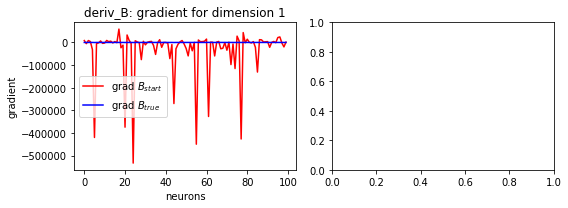

In [35]:
ytmp = np.zeros(MOD.y.shape)
for kk in range(MOD.Ttrials):
    if poisson:
        ytmp[:,:,kk] = np.exp(MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
    else:
        ytmp[:,:,kk] = (MOD.C.dot(MOD.x[:,:,kk].T)+MOD.B.dot(S[:,:,kk].T)).T
mu, sigma = MOD.E_step(MOD.x,MOD.y, MOD.B, MOD.C, MOD.A, MOD.Q, 
                      MOD.Q0, MOD.x0, MOD.R, X=S,
                       poisson=poisson, disp=False)
print('using noiseless y:\n')
print('neg lower bound given random B: ', MOD.L_obs(MOD.C, B0, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson))
print('neg lower bound given true B: ',MOD.L_obs(MOD.C, MOD.B, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson))
fig, ax = plt.subplots(1,2,figsize=(8,3))
for xx in range(S.shape[1]):
    ax[xx].plot(MOD.J_L_obs_B(MOD.C, B0, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson)[:,xx], 'r', label='grad $B_{start}$')
    ax[xx].plot(MOD.J_L_obs_B(MOD.C, MOD.B, ytmp, mu, sigma, X=S, Rtmp=MOD.R, poisson=poisson)[:,xx],'b', label='grad $B_{true}$')
    ax[xx].set_title('deriv_B: gradient for dimension '+np.str(xx+1))
    ax[xx].set_xlabel('neurons')
    ax[xx].set_ylabel('gradient')
ax[0].legend()
fig.tight_layout()

# full EM fitting

In [16]:
from PLDS_Macke2015 import print_par

In [19]:
data = MOD.y.copy()

In [18]:
poisson=False
fit = EM(maxiter=50, gtol=1e-03)
# expect data to be T by ydim by Trials
MOD0 = fit.fit(data=data, xdim=2, poisson=poisson, 
               seed=0, S=None, maxiterem=2,
              cscal=.1, sigQ = 0.001 , a=.1, sigR=.1)

--- iter 0 ---
   lower bound at start  39761224014.865
B closed form solution
   lower bound after iteration  0 :  611251267.8252097
time needed:  162.33824491500854
--- iter 1 ---
B closed form solution
   lower bound after iteration  1 :  594332371.1502639
time needed:  160.54751110076904
time total needed  322.885981798172


In [20]:
print_par(MOD0)

---- latent var parameters ------
A:  [0.6871334  0.88107694]
Q:  [0.00222828 0.02314484]
---- prior parameters -----------
x0:  [-0.58753194 -0.90986994]
Q0:  [0.01705402 0.37158088]
 


# reconstruction error
leave-neuron-out approach/

In [24]:
# create testing data:

# stimulus
S = np.ones([n_step[0], sdim, Ttrials])
if sdim>1:
    S[:,0,:] = np.round(np.random.rand(n_step[0]*Ttrials)).reshape(n_step[0],Ttrials)
S = np.array(S, dtype='int')

MOD.sample(poisson=poisson, X=S, seed=10)

prediction for neuron 0
-------  1.129 sec -------
prediction for neuron 1
-------  1.176 sec -------
prediction for neuron 2
-------  1.023 sec -------
prediction for neuron 3
-------  1.086 sec -------
prediction for neuron 4
-------  1.065 sec -------
prediction for neuron 5
-------  1.046 sec -------
prediction for neuron 6
-------  0.934 sec -------
prediction for neuron 7
-------  1.078 sec -------
prediction for neuron 8
-------  1.08 sec -------
prediction for neuron 9
-------  1.043 sec -------
prediction for neuron 10
-------  1.106 sec -------
prediction for neuron 11
-------  0.933 sec -------
prediction for neuron 12
-------  1.047 sec -------
prediction for neuron 13
-------  0.961 sec -------
prediction for neuron 14
-------  0.985 sec -------
prediction for neuron 15
-------  1.099 sec -------
prediction for neuron 16
-------  1.202 sec -------
prediction for neuron 17
-------  1.095 sec -------
prediction for neuron 18
-------  1.025 sec -------
prediction for neuron 1

Text(0, 0.5, 'estimates')

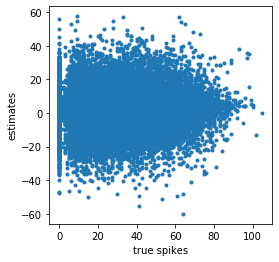

In [131]:
# given a fitted model MOD0 and test data (+stimuli at test time)
pred, mse = fit.reconstruction(data, None, MOD0, poisson=poisson)
plt.figure(figsize=(4,4))
plt.plot(data.ravel(), pred.ravel(), '.')
plt.xlabel('true spikes')
plt.ylabel('estimates')

### own implementation checks

In [21]:
print_par(MOD)
print_par(MOD0)

---- latent var parameters ------
A:  [0.9 0.9]
Q:  [0.1 0.1]
---- prior parameters -----------
x0:  [ 0.16243454 -0.06117564]
Q0:  [0.1 0.1]
 
---- latent var parameters ------
A:  [0.6871334  0.88107694]
Q:  [0.00222828 0.02314484]
---- prior parameters -----------
x0:  [-0.58753194 -0.90986994]
Q0:  [0.01705402 0.37158088]
 


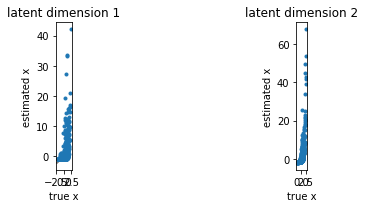

In [22]:
fig, ax = plt.subplots(1,np.max([MOD.xdim,2]), figsize=(8,3))
#X0 = np.random.randn(np.max(MOD0.n_step), MOD0.xdim, MOD0.Ttrials)
mu, sigma = MOD0.E_step(MOD.x, MOD.y, MOD0.B, MOD0.C, MOD0.A, MOD0.Q,
                                   MOD0.Q0, MOD0.x0, MOD0.R, X=S,
                                   poisson=poisson, disp=False)
for aa in range(len(ax)):
    ax[aa].plot(MOD.x[:,aa,:].ravel(), MOD.x[:,aa,:].ravel(),'-', color='grey')
    ax[aa].plot(MOD.x[:,aa,:].ravel(), mu[:,aa,:].ravel(),'.')
    ax[aa].set_xlabel('true x')
    ax[aa].set_ylabel('estimated x')
    ax[aa].set_title('latent dimension '+np.str(aa+1)) 
    ax[aa].set_aspect(1)
fig.tight_layout()

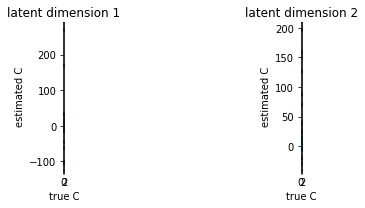

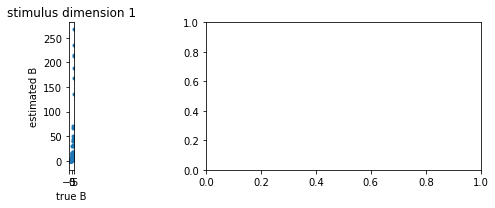

In [23]:
fig, ax = plt.subplots(1,np.max([MOD.xdim,2]), figsize=(8,3))
for aa in range(MOD.xdim):
    ax[aa].plot(MOD.C[:,aa], MOD.C[:,aa],'-', color='grey')
    ax[aa].plot(MOD.C[:,aa], MOD0.C[:,aa],'.')
    ax[aa].set_xlabel('true C')
    ax[aa].set_ylabel('estimated C')
    ax[aa].set_title('latent dimension '+np.str(aa+1)) 
    ax[aa].set_aspect(1)
fig.tight_layout()
fig, ax = plt.subplots(1,np.max([sdim,2]), figsize=(8,3))
for aa in range(sdim):
    ax[aa].plot(MOD.B[:,aa], MOD.B[:,aa],'-', color='grey')
    ax[aa].plot(MOD.B[:,aa], MOD0.B[:,aa],'.')
    ax[aa].set_xlabel('true B')
    ax[aa].set_ylabel('estimated B')
    ax[aa].set_title('stimulus dimension '+np.str(aa+1)) 
    ax[aa].set_aspect(1)
fig.tight_layout()

todo
- implement gaussian observation noise in the exact same way
- Hessian for C and B optimization?
open questions
- update of B: possible analytically or only via likelihood maximization
- Q and Q0 always sytematically too small, why?
- check if derivative of L_obs for C in gaussian case is correct